In [1]:
# Imports
import configparser
from pathlib import Path
import pathlib
from direct_damages import damagescanner_rail_track as ds
import pandas as pd
import geopandas as gpd
# import datetime
from ci_adapt_utilities import *
import pickle
# import networkx as nx
import shapely

In [2]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'collected_flood_runs'

In [3]:
# Define costs for different transport modes
average_train_load_tons = (896+1344+2160+1344+896+896+1344+1512+896+390)/10 # in Tons per train. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
average_train_cost_per_ton_km = (0.014+0.018+0.047+0.045)/4 # in Euros per ton per km. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report
average_road_cost_per_ton_km = (0.395+0.375+0.246+0.203+0.138+0.153+0.125+0.103+0.122+0.099)/10 # in Euros per ton per km. Source: Kennisinstituut voor Mobiliteitsbeleid. 2023. Cost Figures for Freight Transport – final report

In [4]:
# Define basic functions

# Define other functions (development)
def find_basin_lists(basins, regions):
    intersect_basins_regions = gpd.overlay(basins, regions, how='intersection')
    exclude_main_rivers=intersect_basins_regions.loc[intersect_basins_regions['ORDER']==1]

    basins_exclusion_list = [x for x in exclude_main_rivers['HYBAS_ID'].values]
    basin_list_tributaries = set([x for x in intersect_basins_regions['HYBAS_ID'].values if x not in basins_exclusion_list]) 
    basin_list_full_flood = set(intersect_basins_regions['HYBAS_ID'].values)
    return basin_list_tributaries, basin_list_full_flood



In [5]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets=preprocess_assets(assets_path)

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()

print(f"{len(assets)} assets loaded.")

# Read vulnerability and maximum damage data from Nirandjan, S., et al. (2024)
curve_types = {'rail': ['F8.1']}
infra_curves, maxdams = ds.read_vul_maxdam(data_path, hazard_type, infra_type)
max_damage_tables = pd.read_excel(data_path / vulnerability_data / 'Table_D3_Costs_V1.0.0.xlsx',sheet_name='Cost_Database',index_col=[0])
print(f'Found matching infrastructure curves for: {infra_type}')

37779 assets loaded.
Found matching infrastructure curves for: rail


In [6]:
#load pickled shortest paths, disrupted edges, shortest paths, graph
shortest_paths = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'shortest_paths.pkl', 'rb'))
disrupted_edges_by_basin = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'disrupted_edges_by_basin.pkl', 'rb'))
graph_r0 = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'graph_0.pkl', 'rb'))
disrupted_shortest_paths = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'disrupted_shortest_paths.pkl', 'rb'))
event_impacts = pickle.load(open(data_path / 'interim' / 'indirect_damages' / 'event_impacts.pkl', 'rb'))
print('Loaded data from baseline impact assessment')

if 'collect_output' not in locals():
    collect_output_path = f'C:/Data/interim/collected_flood_runs/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

Loaded data from baseline impact assessment


In [7]:
graph_v0=create_virtual_graph(graph_r0)
graph_v=graph_v0.copy()

Max weight: 17100298
Max capacity: 1
Success: only int type values


In [8]:
# Set adaptation data
l1_l2_adapt_path=None#Path(r'C:\Data\input\adaptations\l2_tributary.geojson')
# adapted_area=create_adaptations_gdf(adapt_path)
added_links =[]#[(4424116, 219651487), (219651487, 111997047)]
l4_adapt_path=Path(r'C:\Data\input\adaptations\l4_tributary.geojson')


if l1_l2_adapt_path is not None:
    adapted_area = gpd.read_file(l1_l2_adapt_path).to_crs(3857)
else:
    adapted_area = None
adaptations_df=create_adaptation_df(adapted_area)
if l4_adapt_path is not None:
    adapted_route_area = gpd.read_file(l4_adapt_path).to_crs(3857)
else:
    adapted_route_area = None

In [9]:
asset_options={'bridge_design_rp':'M',
               'tunnel_design_rp':'M'}
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}
adaptation_unit_costs = {'fwall': 7000.97, #considering floodwall in Germany
                         'viaduct': 22500.00*1.3, #considering viaduct is 30% more expensive than ground level
                         'bridge': 3700*10}  #considering bridge of 10m deck width
rp_spec_priority = set_rp_priorities(return_period_dict)

Apply adaptations

In [10]:
if adapted_area is not None:
    assets_to_adapt = filter_assets_to_adapt(assets, adapted_area)
    adapted_assets = assets.loc[assets.index.isin(assets_to_adapt.index)].copy()
    adapted_assets = add_adaptation_columns(adapted_assets)

    for (adaptation_id, ad) in adapted_area.iterrows():
        affected_assets=assets_to_adapt.loc[assets_to_adapt['adaptation_id']==adaptation_id].copy()  
        rp_specs = set(affected_assets['rp_spec'])

        for hazard_map in collect_output.keys():
            haz_rp=hazard_map.split('_')[-3]
            if haz_rp not in rp_specs:
                continue
            overlay_assets = load_baseline_run(hazard_map, interim_data_path, only_overlay=True)
            if set(overlay_assets.asset.values).isdisjoint(affected_assets.index):
                continue
            else: 
                overlay_assets, hazard_numpified_list = load_baseline_run(hazard_map, interim_data_path)
                adapted_assets = apply_asset_adaptations_in_haz_area(adapted_assets, affected_assets, overlay_assets, hazard_numpified_list, rp_spec_priority)
else:
    adapted_assets = assets.iloc[0:0].copy()
    adapted_assets = add_adaptation_columns(adapted_assets)
l3_adaptation_costs = {}
for i,osm_id_pair in enumerate(added_links):
    graph_v, l3_ad_cost = add_l3_adaptation(graph_v, osm_id_pair, adaptation_unit_cost=adaptation_unit_costs['bridge'])
    l3_adaptation_costs[osm_id_pair] = l3_ad_cost
    l3_ad_sum=[i, 'NA', 3, 'NA', l3_ad_cost]
    adaptations_df.loc[i] = l3_ad_sum

if adapted_route_area is not None:
    demand_reduction_dict = add_l4_adaptation(graph_v, shortest_paths, adapted_route_area, demand_reduction=1.0)
    for i,(o,d) in enumerate(demand_reduction_dict.keys()):
        # print('i: ', i)
        # print('od: ',(o,d))
        l4_ad_sum=[i, 'NA', 4, ((o,d),demand_reduction_dict[(o,d)]),0]
        adaptations_df.loc[i] = l4_ad_sum
else:
    demand_reduction_dict = {}

nodes_reduced_demand:       od_nodes  id    prot_area rp_spec adapt_level adapt_size adapt_unit  \
0  node_18494   0  demred_nahe    None        None       None       None   

                         geometry  
0  POINT (875866.273 6419227.260)  
index of nodes_reduced_demand:  ['node_18494']


In [12]:
direct_damages_adapted = {}
indirect_damages_adapted = {}

In [13]:
local_haz_path=data_path/r'Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries'
hazard_data_list = ds.read_hazard_data(local_haz_path, hazard_type, country=country_name, subfolders=None)
print(f'Found {len(hazard_data_list)} hazard maps.')
if adapted_area is not None:
    adapted_area=adapted_area.explode().reset_index(drop=True)
    adapted_area['geometry'] = adapted_area['geometry'].apply(
        lambda x: shapely.LineString(x.exterior) if isinstance(x, (shapely.Polygon, shapely.MultiPolygon)) else x
    )
    adapted_area['buffered'] = shapely.buffer(adapted_area.geometry.values,distance=1)

    l1_adaptation_costs = {}
    for (adaptation_id, ad) in adapted_area.iterrows():
        if ad.adapt_level != 1:
            continue

        for i, single_footprint in enumerate(hazard_data_list):
            hazard_map = single_footprint.parts[-1].split('.')[0]     
            
            haz_rp=hazard_map.split('_')[-3]
            if haz_rp != ad.rp_spec.upper():
                continue
            
            overlay_assets = load_baseline_run(hazard_map, interim_data_path, only_overlay=True)
            if set(overlay_assets.asset.values).isdisjoint(assets_to_adapt.index):
                print('No assets to adapt')
                continue
            if 'fwall' not in ad.prot_area:
                continue
            try:
                adaptation_gdf=gpd.GeoDataFrame(adapted_area.iloc[[adaptation_id]])
                l1_adaptation_costs[adaptation_id] = process_adap_dat(single_footprint, adaptation_gdf, hazard_numpified_list, adaptation_unit_cost=adaptation_unit_costs['fwall'])
                continue

            except Exception as e:
                print(f'Error occurred in {hazard_map}: {str(e)}')
                continue

## MERGE THIS AND THE FOLLOWING CELL AND CALL THEM AS FUNCTIONS

Found 3 hazard maps.


In [14]:
l2_adaptation_costs = {}

for hazard_map in collect_output.keys():
    print('\nProcessing hazard map: ', hazard_map)
    map_rp_spec = hazard_map.split('_')[-3]
    overlay_assets, hazard_numpified_list = load_baseline_run(hazard_map, interim_data_path)
    adaptation_run = run_direct_damage_reduction_by_hazmap(assets, geom_dict, overlay_assets, hazard_numpified_list, collect_output[hazard_map], adapted_assets, map_rp_spec=map_rp_spec, rp_spec_priority=rp_spec_priority, reporting=False, adaptation_unit_cost=adaptation_unit_costs['viaduct'])
    direct_damages_adapted[hazard_map]=adaptation_run
    l2_adaptation_costs[hazard_map] = adaptation_run[2]
    disrupted_edges = disrupted_edges_by_basin[hazard_map]
    indirect_damages_adapted[hazard_map] = run_indirect_damages_by_hazmap(adaptation_run, assets, hazard_map, overlay_assets, disrupted_edges, shortest_paths, graph_v, average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km, demand_reduction_dict)


Processing hazard map:  flood_DERP_RW_H_4326_2080430320
Found matching infrastructure curves for: rail
-- Calculating direct damages --
2024-09-25 17:56:40 - Calculating adapted damages for assets...


100%|██████████| 20/20 [00:00<00:00, 6723.26it/s]

20 assets with no change.


-- Calculating indirect damages --
disrupted_edges baseline:  [('node_12579', 'node_29500'), ('node_12585', 'node_12586'), ('node_12586', 'node_12585'), ('node_12587', 'node_12588'), ('node_12588', 'node_12587'), ('node_17479', 'node_17481'), ('node_17481', 'node_17479'), ('node_22797', 'node_22798'), ('node_22798', 'node_22797'), ('node_29499', 'node_29500'), ('node_29500', 'node_29499'), ('node_29500', 'node_29505'), ('node_29500', 'node_12579'), ('node_29504', 'node_29505'), ('node_29505', 'node_29500'), ('node_29505', 'node_29504'), ('node_31546', 'node_31547'), ('node_31547', 'node_31546'), ('node_40947', 'node_40948'), ('node_40948', 'node_40947')]
disrupted_edges_adapted:  [('node_12579', 'node_29500'), ('node_12585', 'node_12586'), ('node_12586', 'node_12585'), ('node_12587', 'node_12588'), ('node_12588', 'node_12587'), ('node_17479', 'node_17481'), ('node_17481', 'node_17479'), ('node_22797', 'node_22798'), ('node_22798', 'node_22797'), ('node_29499', 'node_29500'), ('node_295

100%|██████████| 42/42 [00:00<00:00, 44496.28it/s]

42 assets with no change.


-- Calculating indirect damages --
disrupted_edges baseline:  [('node_646', 'node_1419'), ('node_1419', 'node_646'), ('node_2454', 'node_2455'), ('node_2455', 'node_2454'), ('node_12579', 'node_12580'), ('node_12579', 'node_35101'), ('node_12579', 'node_29500'), ('node_12580', 'node_12579'), ('node_12581', 'node_12582'), ('node_12582', 'node_12581'), ('node_12585', 'node_12586'), ('node_12586', 'node_12585'), ('node_12587', 'node_12588'), ('node_12588', 'node_12587'), ('node_12592', 'node_31544'), ('node_12599', 'node_12600'), ('node_12600', 'node_12599'), ('node_12600', 'node_29499'), ('node_12609', 'node_29498'), ('node_17479', 'node_17480'), ('node_17479', 'node_17481'), ('node_17480', 'node_17479'), ('node_17481', 'node_17479'), ('node_22797', 'node_22798'), ('node_22797', 'node_29610'), ('node_22798', 'node_22797'), ('node_29498', 'node_12609'), ('node_29498', 'node_29506'), ('node_29499', 'node_29500'), ('node_29499', 'node_12600'), ('node_29500', 'node_29499'), ('node_29500', 'n

100%|██████████| 33/33 [00:00<?, ?it/s]

33 assets with no change.


-- Calculating indirect damages --
disrupted_edges baseline:  [('node_646', 'node_1419'), ('node_1419', 'node_646'), ('node_2454', 'node_2455'), ('node_2455', 'node_2454'), ('node_12579', 'node_12580'), ('node_12579', 'node_35101'), ('node_12579', 'node_29500'), ('node_12580', 'node_12579'), ('node_12581', 'node_12582'), ('node_12582', 'node_12581'), ('node_12585', 'node_12586'), ('node_12586', 'node_12585'), ('node_12587', 'node_12588'), ('node_12588', 'node_12587'), ('node_12592', 'node_31544'), ('node_12599', 'node_12600'), ('node_12600', 'node_12599'), ('node_12600', 'node_29499'), ('node_17479', 'node_17481'), ('node_17481', 'node_17479'), ('node_22797', 'node_22798'), ('node_22798', 'node_22797'), ('node_29499', 'node_29500'), ('node_29499', 'node_12600'), ('node_29500', 'node_29499'), ('node_29500', 'node_29505'), ('node_29500', 'node_12579'), ('node_29501', 'node_29502'), ('node_29502', 'node_29501'), ('node_29502', 'node_40945'), ('node_29503', 'node_29504'), ('node_29504', 'n

In [15]:
event_impacts

{'flood_DERP_RW_H_4326_2080430320': 31081.915397471283,
 'flood_DERP_RW_L_4326_2080430320': 4421860.510617742,
 'flood_DERP_RW_M_4326_2080430320': 4421860.510617742}

In [15]:
sum_l2_ad_costs=sum(sum(asset_dict.values()) for asset_dict in l2_adaptation_costs.values()) # this is float

try:
    adaptations_df.loc[adaptations_df['adapt_level']==1, 'adaptation_cost'] = sum(l1_adaptation_costs.values())
except: pass
try:
    adaptations_df.loc[adaptations_df['adapt_level']==2, 'adaptation_cost'] = sum_l2_ad_costs
except: pass


adaptations_df


,id,prot_area,adapt_level,rp_spec,adaptation_cost


Visualisations

In [16]:
pd.options.display.float_format = "{:,.2f}".format

total_damages_adapted={}
for hazard_map in direct_damages_adapted.keys():

    map_rp_spec = hazard_map.split('_')[-3]

    adap_costs=adaptations_df['adaptation_cost']
    summed_adaptation_costs = sum(adap_costs)

    #direct damages
    dd_bl=direct_damages_adapted[hazard_map][0]
    summed_dd_bl_lower=sum([v[0] for v in dd_bl.values()])
    summed_dd_bl_upper=sum([v[1] for v in dd_bl.values()])
    dd_ad=direct_damages_adapted[hazard_map][1]
    summed_dd_ad_lower=sum([v[0] for v in dd_ad.values()])
    summed_dd_ad_upper=sum([v[1] for v in dd_ad.values()])
    
    #indirect damages
    if hazard_map not in event_impacts.keys():
        print(f'{hazard_map} not in event_impacts')
        id_bl=0
        id_ad=0
        id_ad_cleaned=0
    else:
        id_bl=event_impacts[hazard_map]
        id_ad=indirect_damages_adapted[hazard_map]
        id_ad_cleaned = 0 if id_ad == 99999999999999 else id_ad

    total_damages_adapted[hazard_map]=(map_rp_spec, summed_adaptation_costs, (summed_dd_bl_lower, summed_dd_bl_upper), (summed_dd_ad_lower, summed_dd_ad_upper), id_bl, id_ad_cleaned)
    
total_damages_adapted_df=pd.DataFrame(total_damages_adapted)
total_damages_adapted_df=total_damages_adapted_df.T
total_damages_adapted_df.columns=['return_period','summed_adaptation_costs', 'summed_dd_bl', 'summed_dd_ad', 'indirect damage baseline [€]', 'indirect damage adapted [€]']

# round and turn to million euros for reporting
total_damages_adapted_df_mill=total_damages_adapted_df.copy()
total_damages_adapted_df_mill['summed_adaptation_costs [M€]']=total_damages_adapted_df_mill['summed_adaptation_costs']/1e6
total_damages_adapted_df_mill['summed_dd_bl [M€]']=total_damages_adapted_df_mill['summed_dd_bl'].apply(lambda x: (x[0]/1e6, x[1]/1e6))
total_damages_adapted_df_mill['summed_dd_ad [M€]']=total_damages_adapted_df_mill['summed_dd_ad'].apply(lambda x: (x[0]/1e6, x[1]/1e6))
total_damages_adapted_df_mill['indirect damage baseline [M€]']=total_damages_adapted_df_mill['indirect damage baseline [€]']/1e6
total_damages_adapted_df_mill['indirect damage adapted [M€]']=total_damages_adapted_df_mill['indirect damage adapted [€]']/1e6
total_damages_adapted_df_mill.drop(['summed_adaptation_costs','summed_dd_bl', 'summed_dd_ad', 'indirect damage baseline [€]', 'indirect damage adapted [€]'], axis=1, inplace=True)



custom_order = ['H', 'M', 'L', 'Unknown']

total_damages_adapted_df_mill['return_period'] = pd.Categorical(total_damages_adapted_df_mill['return_period'], 
                                                                categories=custom_order, ordered=True)
sorted_total_damages_adapted_df_mill = total_damages_adapted_df_mill.sort_values(by='return_period', ascending=True)
sorted_total_damages_adapted_df_mill

,return_period,summed_adaptation_costs [M€],summed_dd_bl [M€],summed_dd_ad [M€],indirect damage baseline [M€],indirect damage adapted [M€]
flood_DERP_RW_H_4326_2080430320,H,0.00,"(0.22329212147988414, 0.2743757418432404)","(0.0, 0.0)",0.03,0.03
flood_DERP_RW_M_4326_2080430320,M,0.00,"(0.2784084957824896, 1.0473738201867895)","(0.0, 0.0)",8.84,8.84
flood_DERP_RW_L_4326_2080430320,L,0.00,"(9.355306384249477, 20.914827971012908)","(0.0, 0.0)",44.22,44.22


In [17]:
shortest_paths_assets={}
od_assets=[]
o_geoms=[]
d_geoms=[]
for (o,d), (path, demand) in shortest_paths.items():
    od_assets_by_sp=[]
    o_geoms.append(graph_v.nodes[o]['geometry'])
    d_geoms.append(graph_v.nodes[d]['geometry'])

    for i in range(len(path)-1):
        x=graph_v.edges[path[i], path[i+1], 0]
        od_assets_by_sp.append(x['osm_id'])
        od_assets.append(x['osm_id'])

    shortest_paths_assets[(o,d)]=(od_assets_by_sp, demand)
assets_sps=assets.loc[assets['osm_id'].isin(set(od_assets))].copy()


# Repeat for shortest paths under adapted conditions
shortest_paths_adapted_assets={}
for flood_map, od_dict in disrupted_shortest_paths.items():
    for (o,d), (path, demand) in od_dict.items():
        od_assets_by_sp_adapted=[]
        for i in range(len(path)-1):
            x=graph_v.edges[path[i], path[i+1], 0]
            od_assets_by_sp_adapted.append(x['osm_id'])
        shortest_paths_adapted_assets[flood_map, (o,d)]=(od_assets_by_sp_adapted, demand)


df_shortest_paths=pd.DataFrame(shortest_paths_assets).T
df_shortest_paths.columns=['path', 'demand']
df_shortest_paths


,,path,demand
node_22351,node_22453,"[464230880, 150063654, 150063652, 150029855, 1...",7
node_35282,node_6204,"[338842798, 282864014, 355159266, 885873650, 3...",1
node_18331,node_30909,"[949731416, 227931244, 117470098, 118347946, 1...",1
node_2610,node_6763,"[25778748, 51566456, 25778747, 25778744, 12126...",1
node_2496,node_185,"[25477266, 25477265, 25190052, 25190051, 33361...",1
...,...,...,...
node_22559,node_14048,"[540016760, 150117993, 150117983, 327340447, 5...",630
node_328,node_12365,"[549877826, 52917885, 23588425, 25921685, 2592...",664
node_12365,node_328,"[111740305, 111719233, 453189558, 111719223, 4...",678
node_14048,node_37771,"[186924190, 14281912, 114127704, 114127702, 27...",832


In [18]:

df_shortest_paths_adapted=pd.DataFrame(shortest_paths_adapted_assets).T
df_shortest_paths_adapted.columns=['path', 'demand']
df_shortest_paths_adapted


path  \
flood_DERP_RW_H_4326_2080430320 (node_18494, node_12586)  [119801194, 225456228, 150719350, 150719362, 1...   
                                (node_12586, node_18494)  [320400013, 111997042, 522710348, 522710362, 8...   
                                (node_12586, node_185)    [320400013, 111997042, 522710348, 522710362, 8...   
                                (node_185, node_12586)    [4424116, 593380531, 967231052, 320400005, 111...   
flood_DERP_RW_L_4326_2080430320 (node_18494, node_12586)  [119801194, 225456228, 150719350, 150719362, 1...   
                                (node_12586, node_18494)  [320400013, 111997042, 250029975, 250029978, 3...   
                                (node_12586, node_185)    [320400013, 111997042, 250029975, 250029978, 3...   
                                (node_185, node_12586)    [4424116, 593380531, 967231052, 320400005, 111...   
flood_DERP_RW_M_4326_2080430320 (node_18494, node_12586)  [119801194, 225456228, 150719350, 150719362, 1...   
                                (node_12586, node_18494)  [320400013, 111997042, 250029975, 250029978, 3...   
                                (node_12586, node_185)    [320400013, 111997042, 250029975, 250029978, 3...   
                                (node_185, node_12586)    [4424116, 593380531, 967231052, 320400005, 111...   

                                                         demand  
flood_DERP_RW_H_4326_2080430320 (node_18494, node_12586)      1  
                                (node_12586, node_18494)      1  
                                (node_12586, node_185)      227  
                                (node_185, node_12586)      241  
flood_DERP_RW_L_4326_2080430320 (node_18494, node_12586)      1  
                                (node_12586, node_18494)      1  
                                (node_12586, node_185)      227  
                                (node_185, node_12586)      241  
flood_DERP_RW_M_4326_2080430320 (node_18494, node_12586)      1  
                                (node_12586, node_18494)      1  
                                (node_12586, node_185)      227  
                                (node_185, node_12586)      241

In [19]:

l3_geometries = {}
for u, v, k, attr in graph_v.edges(keys=True, data=True):
    if 'osm_id' not in attr:
        continue
    if 'l3_adaptation' in attr['osm_id']:
        # Ensure the geometry is a valid Shapely geometry object
        geometry = attr['geometry']
        if isinstance(geometry, list) and len(geometry) == 1 and isinstance(geometry[0], shapely.LineString):
            geometry = geometry[0]
        if isinstance(geometry, shapely.LineString):
            l3_geometries[(u, v)] = geometry
        else:
            print(f"Invalid geometry for edge ({u}, {v}): {geometry}")

gdf_l3_edges = gpd.GeoDataFrame.from_dict(l3_geometries, orient='index', columns=['geometry'], geometry='geometry', crs=3857)
gdf_l3_edges.reset_index(inplace=True)

# gdf_l3_edges = gpd.GeoDataFrame(list(l3_geometries.items()), columns=['edge', 'geometry'], geometry='geometry', crs=3857)


In [20]:
# EXPAND FOR VISUALISATION SCRIPT
# Create visualisation for the basin and the discharge points
from lonboard import Map, PolygonLayer, PathLayer, BaseLayer, ScatterplotLayer
import ast
# MIRACA color scheme
color_string = config.get('DEFAULT', 'miraca_colors')
miraca_colors = ast.literal_eval(color_string)

basin_id = 2080430320
rp_vis = 'M'
overlay_assets = load_baseline_run(f'flood_DERP_RW_{rp_vis}_4326_{basin_id}', interim_data_path, only_overlay=True)
    
# Set path for basin to add to visualization
basin_path = rf'C:\Data\Floods\basins\hybas_eu_{int(basin_id)}.shp'

# Generate the basin layer
basin = gpd.read_file(basin_path)
layer_basin = PolygonLayer.from_geopandas(basin,
    get_fill_color=miraca_colors['grey_100'],
    get_line_color=miraca_colors['accent green'], get_line_width=10,
    auto_highlight=False,
    filled=True, opacity=0.1)

# Generate od layer for visualization
od_geoms=o_geoms+d_geoms
od_geoms_gdf=gpd.GeoDataFrame(geometry=od_geoms).set_crs(3857)
layer_od = ScatterplotLayer.from_geopandas(od_geoms_gdf, get_fill_color=miraca_colors['red_danger'], get_radius=200, opacity=0.8, auto_highlight=True)



c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [21]:

# Set path for the protected area to add to visualization
adapt_path = l1_l2_adapt_path
if adapt_path is not None:
    adapt_area = gpd.read_file(adapt_path)
    if len(adapt_area.adapt_level.unique())==1 and adapt_area.adapt_level.unique()[0]==1:
        layer_adapted_area = PolygonLayer.from_geopandas(adapt_area,
                                                         get_fill_color=miraca_colors['green_800'],
                                                         get_line_color=miraca_colors['primary blue'], get_line_width=10,
                                                         auto_highlight=False, filled=True, opacity=0.1)
    else:
        layer_adapted_area = None
else:
    layer_adapted_area = None

# Create layer for assets for visualization
layer_assets = PathLayer.from_geopandas(assets.drop(columns=['buffered', 'other_tags']), get_width=80, get_color=miraca_colors['grey_400'], auto_highlight=True, )
layer_shortest_path_assets = PathLayer.from_geopandas(assets_sps.drop(columns=['buffered', 'other_tags']), get_width=80, get_color=miraca_colors['black'], auto_highlight=True)
affected_assets = [asset_id for asset_id in list(set(overlay_assets.asset.values))]
layer_affected_assets = PathLayer.from_geopandas(assets.iloc[affected_assets].drop(columns=['buffered', 'other_tags']), get_width=80, get_color=miraca_colors['red_danger'], auto_highlight=True)

try:
    layer_protected_assets = PathLayer.from_geopandas(adapted_assets.drop(columns=['buffered', 'other_tags']), get_width=90, get_color=miraca_colors['green_success'], auto_highlight=True)
except:
    layer_protected_assets = None
try:
    layer_l3_edges = PathLayer.from_geopandas(gdf_l3_edges, get_width=90, get_color=miraca_colors['green_success'])
except:
    layer_l3_edges = None
layer_assets_raw = [layer_assets, layer_shortest_path_assets, layer_affected_assets, layer_protected_assets, layer_l3_edges]
layers_assets = [layer for layer in layer_assets_raw if layer is not None]

# Generate flood layers and protection layers for visualization
flood_plot_path=rf'Floods\Germany\basin_intersections\DERP_RW_{rp_vis}_4326_hybas_intersections\flood_DERP_RW_{rp_vis}_4326_{basin_id}.geojson'
flood_m = data_path / flood_plot_path
flood_gdf=gpd.read_file(flood_m)
layers_flood=[]
f_area_colors = {1:'blue', 3:'green'}
for f_area in flood_gdf.flood_area.unique():
    for f_depth in flood_gdf.depth_class.unique():
        subset_gdf = flood_gdf[(flood_gdf.depth_class==f_depth) & (flood_gdf.flood_area==f_area)]
        if not subset_gdf.empty:
            color_key=f'{f_area_colors[f_area]}_{f_depth}00'
            layers_flood.append(PolygonLayer.from_geopandas(subset_gdf, 
                                                            get_fill_color=miraca_colors[color_key], 
                                                            opacity=0.5, 
                                                            stroked=False))

layers=[]
if layer_basin is not None:
    layers.append(layer_basin)
else:
    print('No basin layer')

if layer_adapted_area is not None:
    layers.append(layer_adapted_area)
else:
    print('No protected area layer')

if layers_flood is not None:
    layers.extend(layers_flood)
else:
    print('No flood layers')

if layer_assets is not None:
    layers.extend(layers_assets)
else:
    print('No asset layer')
Voyager = 'https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json'

if layer_od is not None:
    layers.append(layer_od)
else:
    print('No od layer')
m = Map(layers, show_tooltip=True, basemap_style=Voyager, view_state={"longitude": 7.91, "latitude": 49.91, "zoom": 11})


c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


No protected area layer


In [24]:
m

Map(basemap_style='https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json', layers=[PolygonLayer(filled=…

In [70]:
plot_assets=assets.drop(columns=['buffered', 'other_tags']).to_crs(epsg=4326)
plot_assets.head(3)

,osm_id,asset,name,gauge,electrified,voltage,bridge,maxspeed,service,tunnel,railway:traffic_mode,usage,geometry
0,3568324,rail,None,1435,contact_line,15000,yes,None,None,None,None,"""main""","LINESTRING (8.62626 49.81501, 8.62621 49.81489)"
1,3568326,rail,None,1435,contact_line,15000,yes,160,None,None,None,"""main""","LINESTRING (8.60882 49.72625, 8.60886 49.72606)"
2,3568327,rail,None,1435,contact_line,15000,None,160,None,None,None,"""main""","LINESTRING (8.61315 49.70201, 8.61323 49.70154..."


Zoom Level: 12


ValueError: aspect must be finite and positive 

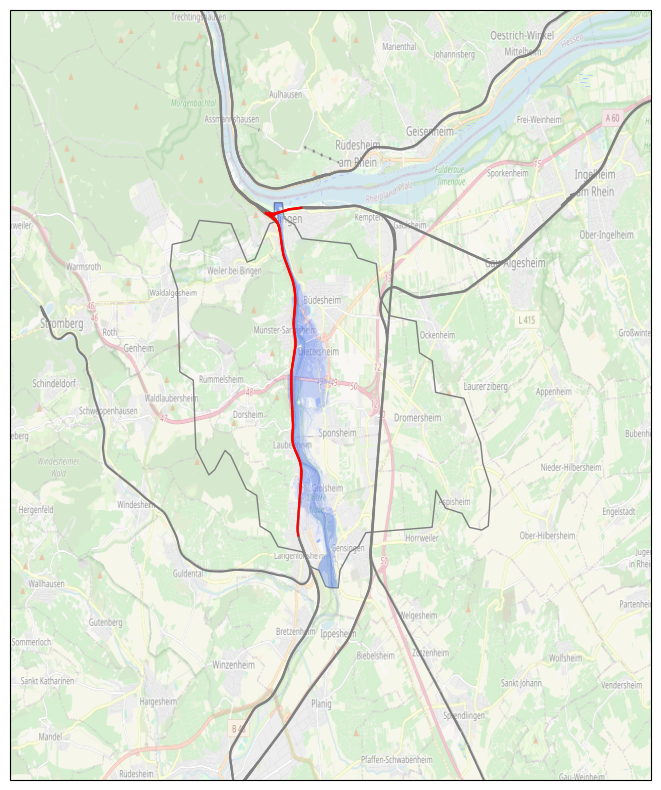

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import geopandas as gpd

# helper function
def zoomlevel_from_deg(deg): #https://stackoverflow.com/questions/30052990/how-to-use-openstreetmap-background-on-matplotlib-basemap
    "Calculate OSM zoom level from a span in degrees.  Adjust +/-1 as desired"
    from numpy import log2, clip, floor
    zoomlevel = int(clip(floor(log2(360) - log2(delta)),0,20 ))
    return zoomlevel 

# Convert basin to EPSG:4326 and get the total bounds
extent = basin.to_crs(epsg=4326).total_bounds

# Add clearance around the basin
clearance = 0.5  # 10% clearance around the basin bounds
lon_min, lat_min, lon_max, lat_max = extent
lon_range = lon_max - lon_min
lat_range = lat_max - lat_min

lon_min -= clearance * lon_range
lat_min -= clearance * lat_range
lon_max += clearance * lon_range
lat_max += clearance * lat_range

# Calculate aspect ratio
aspect_ratio = lon_range / lat_range

lon_i = lon_min + (lon_max - lon_min) / 2
lat_i = lat_min + (lat_max - lat_min) / 2
delta = 0.0016 # 0.0012 # 38 to 0.0002 degrees to avoid north pole
zoom = zoomlevel_from_deg(delta)-5 # 10 #  0-19 
print(f"Zoom Level: {zoom}")

# Create a plot with the OSM tiles
request_osm = cimgt.OSM()

fig = plt.figure(figsize=(10 * aspect_ratio, 10))
ax = plt.axes(projection=request_osm.crs)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_image(request_osm, zoom, alpha=0.5)  # Adjust zoom level as needed

# Plot the basin
basin.to_crs(epsg=4326).plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=1, transform=ccrs.PlateCarree())

# Plot the assets
plot_assets.plot(ax=ax, color='grey', markersize=10, transform=ccrs.PlateCarree())

# Plot the flood areas
for f_area in flood_gdf.flood_area.unique():
    for f_depth in flood_gdf.depth_class.unique():
        subset_gdf = flood_gdf[(flood_gdf.depth_class==f_depth) & (flood_gdf.flood_area==f_area)]
        if not subset_gdf.empty:
            color_key=f'{f_area_colors[f_area]}_{f_depth}00'
            subset_gdf.to_crs(epsg=4326).plot(ax=ax, facecolor=miraca_colors[color_key], edgecolor=None, linewidth=2, alpha=0.5, transform=ccrs.PlateCarree())

# Plot the shortest paths
plot_assets_sps = assets_sps.drop(columns=['buffered', 'other_tags']).to_crs(epsg=4326)
plot_assets_sps.plot(ax=ax, color='black', markersize=10, transform=ccrs.PlateCarree())

# Plot the affected assets
plot_assets_affected = assets.iloc[affected_assets].drop(columns=['buffered', 'other_tags']).to_crs(epsg=4326)
plot_assets_affected.plot(ax=ax, color='red', markersize=10, transform=ccrs.PlateCarree())

# Plot the OD points
od_geoms_gdf.to_crs(epsg=4326).plot(ax=ax, color='blue', markersize=10, transform=ccrs.PlateCarree())

ax.gridlines(draw_labels=True)
plt.show()

Zoom Level: 12


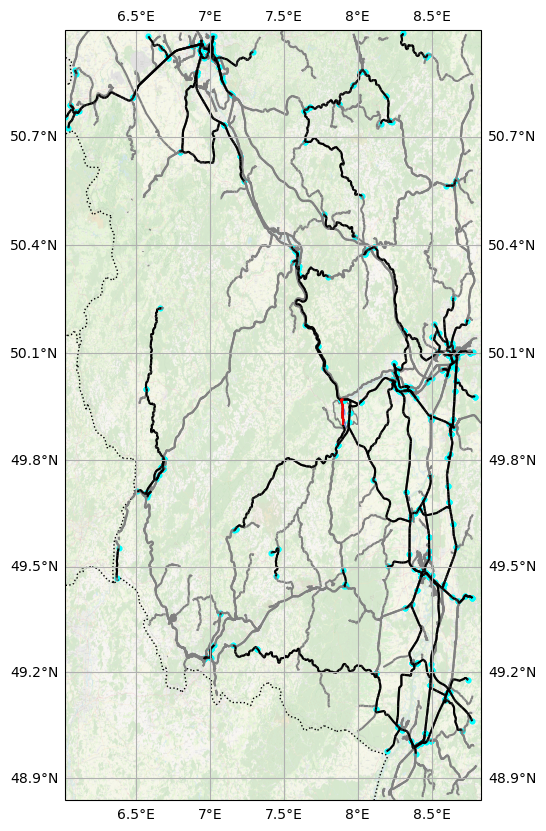

In [28]:
import cartopy
# Convert basin to EPSG:4326 and get the total bounds
extent_new = assets.to_crs(epsg=4326).total_bounds

# Add clearance around the basin
clearance = 0  # 10% clearance around the basin bounds

lon_min_new, lat_min_new, lon_max_new, lat_max_new = extent_new
lon_range_new = lon_max_new - lon_min_new
lat_range_new = lat_max_new - lat_min_new

lon_min_new -= clearance * lon_range_new
lat_min_new -= clearance * lat_range_new
lon_max_new += clearance * lon_range_new
lat_max_new += clearance * lat_range_new

# Calculate aspect ratio
aspect_ratio_new = lon_range_new / lat_range_new

lon_i_new = plot_assets.total_bounds[0] + (plot_assets.total_bounds[2] - plot_assets.total_bounds[0]) / 2
lat_i_new = plot_assets.total_bounds[1] + (plot_assets.total_bounds[3] - plot_assets.total_bounds[1]) / 2
delta_new = 0.0016 # 0.0012 # 38 to 0.0002 degrees to avoid north pole
zoom_new = zoomlevel_from_deg(delta_new)-5 # 10 #  0-19
print(f"Zoom Level: {zoom_new}")

fig = plt.figure(figsize=(10 * aspect_ratio_new, 10))
ax = plt.axes(projection=request_osm.crs)
ax.set_extent([lon_min_new, lon_max_new, lat_min_new, lat_max_new], crs=ccrs.PlateCarree())
ax.add_image(request_osm, zoom_new, alpha=0.5)  # Adjust zoom level as needed

# Plot the basin
basin.to_crs(epsg=4326).plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=1, transform=ccrs.PlateCarree())

# Plot the assets
plot_assets.plot(ax=ax, color='grey', markersize=10, transform=ccrs.PlateCarree())

# Plot the flood areas
for f_area in flood_gdf.flood_area.unique():
    for f_depth in flood_gdf.depth_class.unique():
        subset_gdf = flood_gdf[(flood_gdf.depth_class==f_depth) & (flood_gdf.flood_area==f_area)]
        if not subset_gdf.empty:
            color_key=f'{f_area_colors[f_area]}_{f_depth}00'
            subset_gdf.to_crs(epsg=4326).plot(ax=ax, facecolor=miraca_colors[color_key], edgecolor=None, linewidth=2, alpha=0.5, transform=ccrs.PlateCarree())

# Plot the shortest paths
plot_assets_sps = assets_sps.drop(columns=['buffered', 'other_tags']).to_crs(epsg=4326)
plot_assets_sps.plot(ax=ax, color='black', markersize=10, transform=ccrs.PlateCarree())

# Plot the affected assets
plot_assets_affected = assets.iloc[affected_assets].drop(columns=['buffered', 'other_tags']).to_crs(epsg=4326)
plot_assets_affected.plot(ax=ax, color='red', markersize=10, transform=ccrs.PlateCarree())

# Plot the OD points
od_geoms_gdf.to_crs(epsg=4326).plot(ax=ax, color='cyan', markersize=10, transform=ccrs.PlateCarree())

ax.gridlines(draw_labels=True)

# add administrative boundaries
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
plt.show()

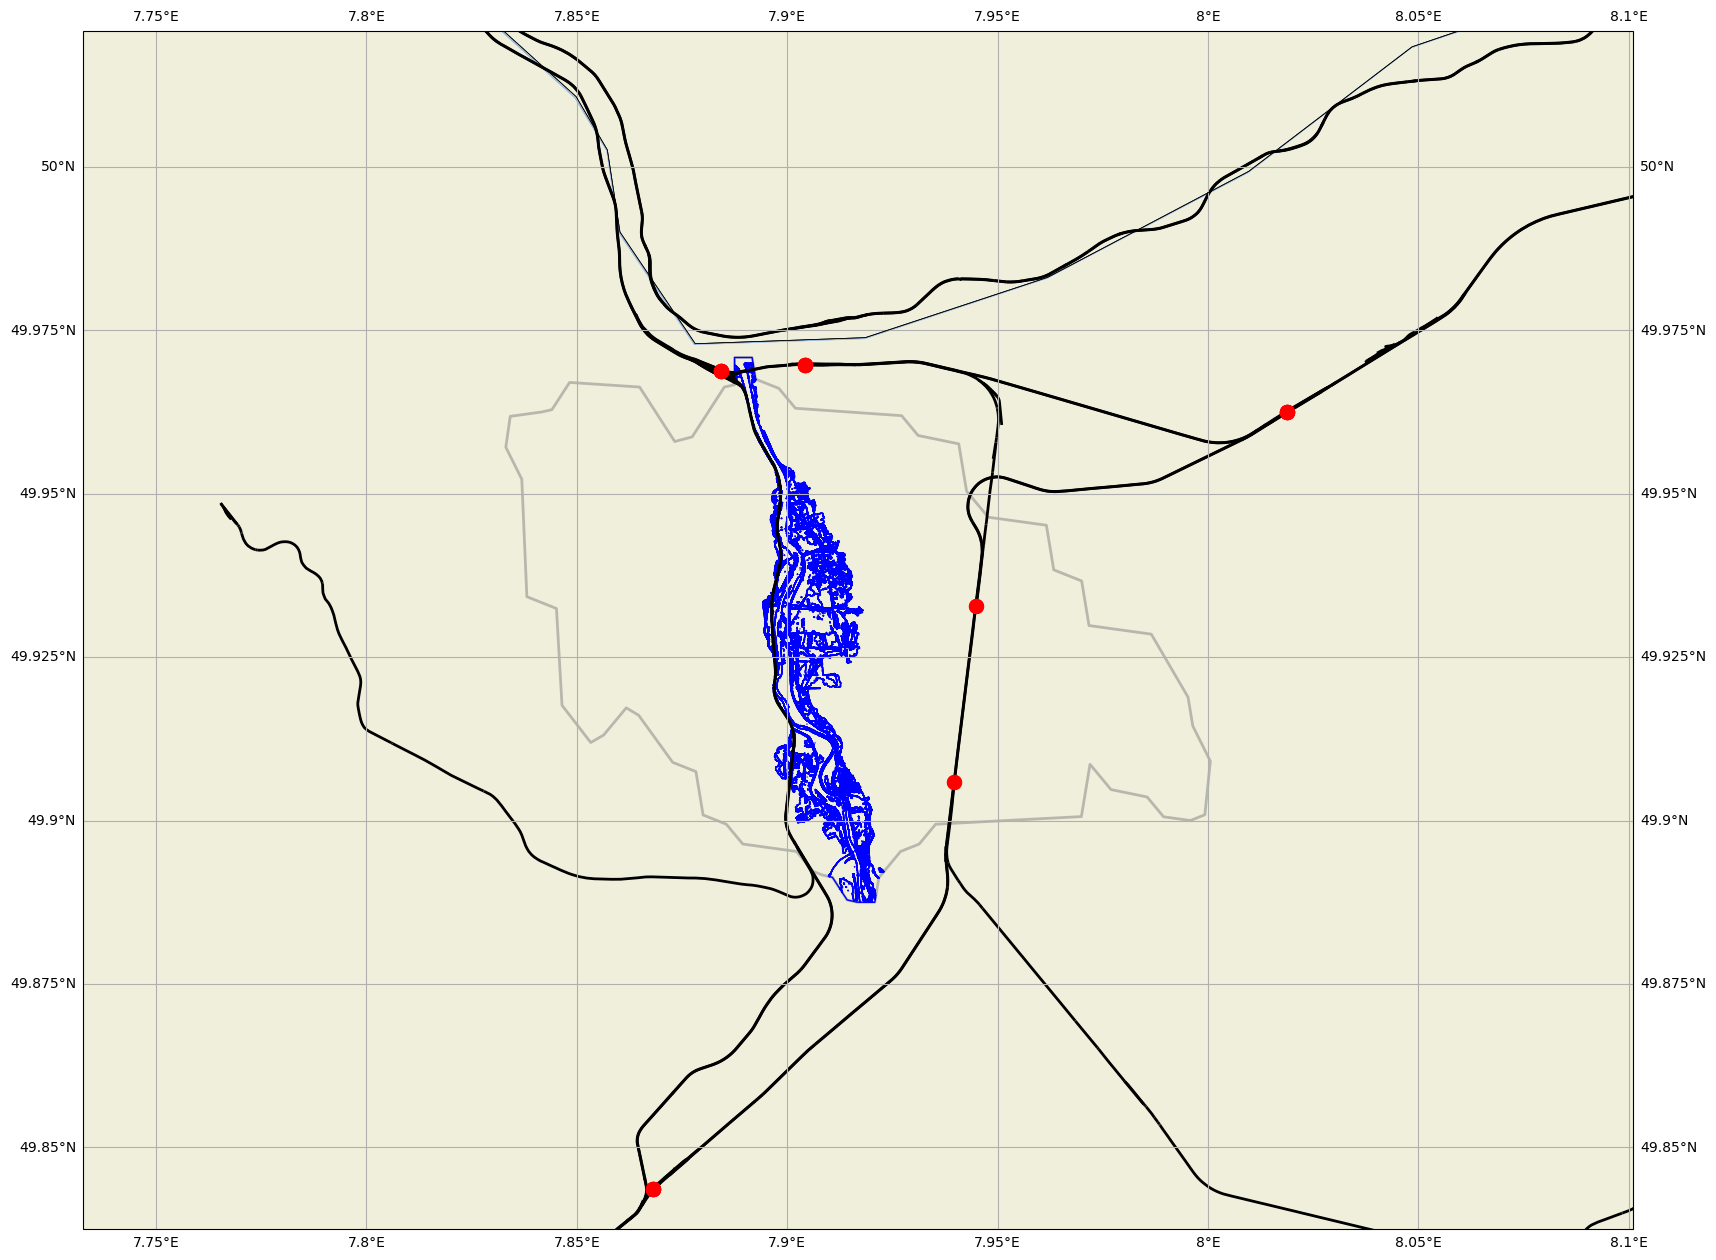

In [59]:
#!pip install cartopy
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pyproj

# Define the transformer to convert from EPSG:3857 to EPSG:4326
transformer = pyproj.Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

# Convert coordinates of o_geoms and d_geoms to EPSG:4326
o_geoms_4326 = [transformer.transform(geom.x, geom.y) for geom in o_geoms]
d_geoms_4326 = [transformer.transform(geom.x, geom.y) for geom in d_geoms]

# Create a map with the basin and the origins and destinations
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the basin (assuming basin is in EPSG:3857)
# If basin is in EPSG:3857, convert it to EPSG:4326
basin = basin.to_crs(epsg=4326)
basin.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=2, alpha = 0.5)

# Plot the assets
plot_assets.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

# Plot the flood areas
flood_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=1)

# Plot the protected area
# adapted_area.plot(ax=ax, facecolor='none', edgecolor='green', linewidth=2)

# Plot the shortest paths  
for (o,d), (path, demand) in shortest_paths.items():
    path_coords = [graph_v.nodes[node]['geometry'] for node in path]
    ax.plot([geom.x for geom in path_coords], [geom.y for geom in path_coords], 'b-', linewidth=2)

# Set the extent of the map based on basin boundaries
lon_min, lat_min, lon_max, lat_max = basin.total_bounds


# Plot the origins and destinations
for lon, lat in o_geoms_4326:
    ax.plot(lon, lat, 'ro', markersize=10)
for lon, lat in d_geoms_4326:
    ax.plot(lon, lat, 'ro', markersize=10)


# Calculate the range for longitude and latitude
lon_range = lon_max - lon_min
lat_range = lat_max - lat_min
# Add clearance around the basin
clearance = 0.6  # that is 60% of the range between min and max lon and lat on either side
# Apply clearance
lon_min -= clearance * lon_range
lat_min -= clearance * lat_range
lon_max += clearance * lon_range
lat_max += clearance * lat_range


ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add basemap
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)    

# Add states and provinces
states_provinces = cartopy.feature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces',
            scale='10m', facecolor='none')
ax.add_feature(states_provinces, edgecolor='black', zorder=10, linestyle = '-', linewidth=0.5)

# Add buildings
# buildings = cartopy.feature.NaturalEarthFeature(
#             category='cultural',  name='buildings',
#             scale='10m', facecolor='none')
# ax.add_feature(buildings, edgecolor='black', zorder=10, linestyle = '-', linewidth=0.5)

ax.gridlines(draw_labels=True)
plt.show()

In [27]:
m

Map(basemap_style='https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json', layers=[PolygonLayer(filled=…

In [46]:
adapted_edges=[(u,v,k) for u,v,k,attr in graph_v.edges(keys=True, data=True) if 'osm_id' in attr and 'l3_adaptation' in attr['osm_id']]
print(adapted_edges)
# shortest_paths
# assets_in_sps2=shortest_paths_assets[('node_164', 'node_10409')]
assets_in_sps2=shortest_paths_assets[('node_164', 'node_11238')]
# shortest_paths[('node_164', 'node_11238')]
# assets_in_sps2
# [(u,v) for (u,v), (path, demand) in shortest_paths_assets.items() if '111997044' in path]
disrupted_shortest_paths['flood_DERP_RW_L_4326_2080430320'][('node_164', 'node_11238')]==shortest_paths[('node_164', 'node_11238')]
print('shortest_paths: ', shortest_paths[('node_164', 'node_11238')])
print('disrupted_shortest_paths: ', disrupted_shortest_paths['flood_DERP_RW_L_4326_2080430320'][('node_164', 'node_11238')])





[]
shortest_paths:  (['node_164', 'node_165', 'node_36108', 'node_31959', 'node_11222', 'node_11203', 'node_8174', 'node_8173', 'node_8171', 'node_8172', 'node_8175', 'node_32233', 'node_2141', 'node_2142', 'node_2143', 'node_2231', 'node_2232', 'node_11214', 'node_11217', 'node_11221', 'node_11212', 'node_11213', 'node_11216', 'node_26123', 'node_11208', 'node_11209', 'node_5656', 'node_5655', 'node_11204', 'node_11205', 'node_28928', 'node_28929', 'node_11244', 'node_11245', 'node_11237', 'node_11238'], 241)
disrupted_shortest_paths:  (['node_164', 'node_165', 'node_36108', 'node_31959', 'node_11222', 'node_11203', 'node_8174', 'node_8173', 'node_8171', 'node_8172', 'node_8175', 'node_32233', 'node_2141', 'node_2142', 'node_2143', 'node_2231', 'node_2232', 'node_11214', 'node_11217', 'node_11221', 'node_11212', 'node_11213', 'node_11216', 'node_26123', 'node_11208', 'node_11209', 'node_5656', 'node_11218', 'node_11202', 'node_11201', 'node_26130', 'node_3137', 'node_3135', 'node_3136

In [15]:

basins_path = gpd.read_file(data_path / r'Floods\basins\hybas_eu_lev01-12_v1c\hybas_eu_lev08_v1c_valid.shp')
regions_path = gpd.read_file(data_path / r'QGIS_data\rhineland_palatinate.geojson')

basin_list_tributaries, basin_list_full_flood = find_basin_lists(basins_path, regions_path)



In [ ]:
#!pip install seaborn
#PLOT INDIRECT DAMAGES AND DIRECT DAMGES FOR EACH HAZARD MAP SORTED BY SUMMED ADAPTATION COSTS
import matplotlib.pyplot as plt
import seaborn as sns
total_damages_adapted_df_mill=total_damages_adapted_df_mill.sort_values(by='summed_adaptation_costs')
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x='summed_adaptation_costs', y='hazard_map', data=total_damages_adapted_df_mill, palette='viridis', ax=ax)
ax.set_xlabel('Summed adaptation costs [M€]')
ax.set_ylabel('Hazard map')
plt.show()

In [ ]:
# indirect damages adapted vs baseline
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x='indirect damage adapted [M€]', y='hazard_map', data=total_damages_adapted_df_mill, palette='viridis', ax=ax)
ax.set_xlabel('Indirect damage adapted [M€]')
ax.set_ylabel('Hazard map')
plt.show()


In [ ]:
#!pip install seaborn
#adaptation cost for each basin/hazard map
import matplotlib.pyplot as plt
import seaborn as sns
total_damages_adapted_df_mill=total_damages_adapted_df_mill.sort_values(by='summed_adaptation_costs')
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.barplot(x='summed_adaptation_costs', y='hazard_map', data=total_damages_adapted_df_mill, palette='viridis', ax=ax)
ax.set_xlabel('Summed adaptation costs [M€]')
ax.set_ylabel('Hazard map')
plt.show()

In [17]:
import os

# Define the baseline return periods 
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}

# Add climate change: calculate the dynamic return periods based on flat increase factors. 
# This value has been catchment-specific with frequency increasing in some regions and decreasing in others. 
# It is reasonable that in the future, the frequency will continue to change differently by catchment.

increase_factor = {
    '_H_': 2,
    '_M_': 4.3,
    '_L_': 5
} # https://hess.copernicus.org/preprints/hess-2016-65/hess-2016-65-manuscript-version2.pdf 


num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)



In [18]:
sorted_total_damages_adapted_df_mill

,return_period,summed_adaptation_costs [M€],summed_dd_bl [M€],summed_dd_ad [M€],indirect damage baseline [M€],indirect damage adapted [M€]
flood_DERP_RW_H_4326_2080430320,H,0.00,"(0.22329212147988414, 0.2743757418432404)","(0.0, 0.0)",0.03,0.03
flood_DERP_RW_M_4326_2080430320,M,0.00,"(0.2784084957824896, 1.0473738201867895)","(0.0, 0.0)",4.42,4.42
flood_DERP_RW_L_4326_2080430320,L,0.00,"(9.355306384249477, 20.914827971012908)","(0.0, 0.0)",4.42,4.42


In [19]:
event_impacts.keys()

dict_keys(['flood_DERP_RW_H_4326_2080430320', 'flood_DERP_RW_L_4326_2080430320', 'flood_DERP_RW_M_4326_2080430320'])

In [20]:
aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))

# summed_output  is a dicitonary of with keys as the hazard map names and values as a tuple of the lower and upper bounds of the total damage
# example: {'flood_DERP_RW_H_4326_2080411370': (3706407.631635442, 13355041.119988918),

# for a list of all the basins in the region, retrieve the upper and lower damage bounds for each basin and skip if the basin is not a key in the summed_output dictionary

# create a dictionary of dictionaries with the basin number as the level 1 key, the category (ie "H") as the level 2 key and the upper and lower bounds as the values
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in event_impacts.keys():
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = sorted_total_damages_adapted_df_mill.loc[key]['summed_dd_ad [M€]']


aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue
    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)
    aggregated_df_by_basin[basin]['Probability'] = [[1 / x for x in i] for i in aggregated_df_by_basin[basin]['Return Period']]
    probabilities = aggregated_df_by_basin[basin]['Probability']
    dmgs = []

    for ts in range(len(probabilities.iloc[0])):    
        dmgs_l = []
        dmgs_u = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
            trap_damage_l = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp + 1])
            trap_damage_u = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp + 1])
            dmgs_l.append(d_rp * trap_damage_l)
            dmgs_u.append(d_rp * trap_damage_u)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities.iloc[-1][ts]
        damage_l0 = max(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u0 = max(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d0_rp * damage_l0)
        dmgs_u.append(d0_rp * damage_u0)

        d_end_rp = (1/4)-probabilities.iloc[0][ts]
        damage_l_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d_end_rp * damage_l_end)
        dmgs_u.append(d_end_rp * damage_u_end)

        dmgs.append((sum(dmgs_l), sum(dmgs_u)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])



ead_y0_dd_ad = ead_by_ts_by_basin[basin].values[0]
ead_y100_dd_ad = ead_by_ts_by_basin[basin].values[-1]
total_cost_dd_ad = sum(ead_by_ts_by_basin[basin].values)
print(f'EAD at year 0 for basin {basin}: {ead_y0_dd_ad}')
print(f'EAD at year 100 for basin {basin}: {ead_y100_dd_ad}')
print(f'Total direct damages for basin {basin}: {total_cost_dd_ad}')

EAD at year 0 for basin 2080430320: [0. 0.]
EAD at year 100 for basin 2080430320: [0. 0.]
Total direct damages for basin 2080430320: [0. 0.]


In [21]:
files = [file for file in os.listdir('C:/Data/interim/collected_flood_runs') if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in event_impacts.keys():
        if not str(basin) in key:
            continue
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = sorted_total_damages_adapted_df_mill.loc[key]['indirect damage adapted [M€]']


for rp in return_period_dict.keys():
    # add rp as a key to all nested dictionaries with 0 as a value if the rp is not already a key
    for basin in basin_dict.keys():
        if rp not in basin_dict[basin].keys():
            basin_dict[basin][rp] = 0


aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue

    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total indirect damage'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    probabilities = [[1 / rp for rp in ts] for ts in aggregated_df_by_basin[basin]['Return Period']]
    aggregated_df_by_basin[basin]['Probability'] = probabilities
    dmgs = []

    for ts in range(len(probabilities[0])):    
        dmgs_m = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities[rp][ts] - probabilities[rp + 1][ts]
            trap_damage_m = 0.5 * (aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp] + aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp + 1])
            dmgs_m.append(d_rp * trap_damage_m)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities[-1][ts]
        damage_m0 = max(aggregated_df_by_basin[basin]['Total indirect damage'])
        dmgs_m.append(d0_rp * damage_m0)

        d_end_rp = (1/4)-probabilities[0][ts]
        damage_m_end = 0.5 * min(aggregated_df_by_basin[basin]['Total indirect damage'])

        dmgs_m.append(d_end_rp * damage_m_end)

        dmgs.append((sum(dmgs_m)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total indirect damage'])

ead_y0_id_ad = ead_by_ts_by_basin[basin].values[0]
ead_y100_id_ad = ead_by_ts_by_basin[basin].values[-1]
total_cost_id_ad = sum(ead_by_ts_by_basin[basin].values)
print(f'EAD at year 0 for basin {basin}: {ead_y0_id_ad}')
print(f'EAD at year 100 for basin {basin}: {ead_y100_id_ad}')
print(f'Total indirect losses for basin {basin}: {total_cost_id_ad}')

EAD at year 0 for basin 2080430320: [0.23595775]
EAD at year 100 for basin 2080430320: [0.50096146]
Total indirect losses for basin 2080430320: [37.21441972]


In [ ]:

print(direct_damages_adapted['flood_DERP_RW_H_4326_2080411370'][2])

# Ensure each entry in event_impacts contains both 'direct_damages' and 'indirect_damages'
# Adjust the dictionary if necessary
for key, value in event_impacts.items():
    if isinstance(value, dict):
        if 'direct_damages' not in value:
            value['direct_damages'] = 0  # or some default value
        if 'indirect_damages' not in value:
            value['indirect_damages'] = 0  # or some default value
    else:
        event_impacts[key] = {'direct_damages': direct_damages_adapted[key][0], 'indirect_damages': value}  # or some default value

# Create the DataFrame
baseline_impacts_by_hazard_map = pd.DataFrame.from_dict(event_impacts, orient='index', columns=['direct_damages', 'indirect_damages'])
baseline_impacts_by_hazard_map